In [50]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split,StratifiedKFold # Model evaluation
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet,  LassoLarsIC, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import explained_variance_score, f1_score, roc_auc_score, median_absolute_error, r2_score, mean_squared_error #To evaluate our model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMRegressor
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

In [43]:
import pandas as pd
import numpy as np
import re
import numpy as np

In [44]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
testId = test.Property_Id
train.Price_Category = train.Price_Category.replace("Cheap",0).replace("Affordable",1).replace("Semi-Premium",2).replace("Premium",3)
y = train.Price_Category
train = train.drop(["Property_Id", "Price_Category"],axis=1)
test = test.drop(["Property_Id"],axis=1)
features = pd.concat([train,test])
train.head(1)

,Title,Label,Type,Location,Baths,Area,Purpose,Bedroom(s),Description,Main Features,Rooms,Business and Communication,Healthcare Recreational,Nearby Locations and Other Facilities,Other Facilities,Popular,Source,Time Stamp
0,Brand New 1 Kanal House For Sale In Bahria Tow...,"Bahria Town - Gulbahar Block, Bahria Town - Se...",House,"Bahria Town, Lahore, Punjab",6,1 Kanal,For Sale,5,Brand New 1 Kanal House For Sale In Bahria Tow...,"Built in year: 2018 , Parking Spaces: 4 , Dou...","Bedrooms: 5 , Bathrooms: 7 , Servant Quarters...","Broadband Internet Access , Satellite or Cabl...","Lawn or Garden , Swimming Pool","Nearby Schools , Nearby Hospitals , Nearby Sh...","Maintenance Staff , Security Staff , Faciliti...",super hot,Lahore-1-10,3/31/2019 11:01


In [45]:
def findWcolon(a,x, length):
    val = re.findall("%s: \d+" % a,x)
    val = val[0][-length:] if len(val)>0 else (np.nan if len(x)==1 else 0)
    return val
def find(a,x):
    return 1 if a in x else (np.nan if len(x)==1 else 0)

def rooms(x):
    living = find("Study Room",x) + find("Drawing Room",x) + find("Dining Room",x) + find("Lounge or Sitting Room", x)
    athletic = find("Gym",x) + find("Steam Room",x) + find("Laundry Room",x) + find("Powder Room", x)
    #findWcolon("Bathrooms",x,1),
    return [findWcolon("Servant Quarters",x,1), findWcolon("Kitchens",x,1), findWcolon("Store Rooms",x,1), living, athletic, find("Other Rooms", x), find("Steam Room",x), find("Laundry Room",x), find("Powder Room", x), find("Study Room",x), find("Drawing Room",x), find("Dining Room",x), find("Lounge or Sitting Room", x)]

def main_features(x):
    return [findWcolon("Built in year",x,4), findWcolon("Parking Spaces",x,1), findWcolon("Floors",x,1), find("Double Glazed Windows", x), find("Flooring", x), find("Electricity Backup", x), find("Waste Disposal", x),find("Central Air Conditioning", x), find("Flooring", x)]

def business(x):
    return [find("Broadband Internet Access", x), find("Satellite or Cable TV Ready", x), find("Intercom", x), find("Other Business and Communication Facilities", x)]

def health(x):
    return [find("Lawn or Garden", x), find("Sauna", x) + find("Jacuzzi", x), find("Swimming Pool", x), find("Other Healthcare and Recreation Facilities", x)]

def facilities(x):
    cols = ['Maintenance Staff','Security Staff','Facilities for Disabled','Other Facilities']
    return [find(y,x) for y in cols]

def nearby(x):
    val = len([y for y in x.split(" , ") if "Nearby" in y]) if x != " " else np.nan
    return val

def Label(x):
    vals = x.split(",")
    new = []
    if len(vals)==3:
        new += [np.nan, np.nan]
    if len(vals)==4:
        new += [vals[0],np.nan]
    if len(vals) >= 5:
        new += vals[:2]
    return new

def process(train):
    train["nearbyVal"] = [1 if len(x) > 1 else 0 for x in train["Nearby Locations and Other Facilities"]]
    train["bussinessVal"] = [1 if len(x) > 1 else 0 for x in train["Business and Communication"]]
    train["staffVal"] = [1 if len(x) > 1 else 0 for x in train["Other Facilities"]]
    train["healthVal"] = [1 if len(x) > 1 else 0 for x in train["Healthcare Recreational"]]
    train[["Date","Parking","Floors","Windows", "Flooring", "ElectricBackup", "WasteDisposal", "CentralAir", "CentralHeating"]] = list(train["Main Features"].apply(main_features))
    train[["Servants","Kitchens","Store Rooms", "living","healthRooms","OtherRooms", "Steam Room","Laundry Room","Powder Room","Study Room","Drawing Room","Dining Room","Lounge"]] = list(train.Rooms.apply(rooms))
    train[["internet","tv","intercom","otherBusiness"]] = list(train["Business and Communication"].apply(business))
    train[["town","city","province"]] = list(train.Location.apply(lambda x: x.split(",")))
    train[["lawn","hotTub","pool","otherHealth"]] = list(train["Healthcare Recreational"].apply(health))
    
    train.Area = ["".join(x.split(",")) for x in train.Area]
    train["Metric"] = [1 if x.split(" ")[1] == "Kanal" else 0 for x in train.Area]
    train.Area = train.Area.apply(lambda x: float(x.split(" ")[0]) if x.split(" ")[1] == "Marla" else float(x.split(" ")[0]) *20)
   
    train[['MaintenanceStaff','SecurityStaff','FacilitiesDisabled','ExtraFacilities']] = list(train["Other Facilities"].apply(facilities))
    train["nearby2"] = train["Nearby Locations and Other Facilities"].apply(nearby)
    train.Popular = train.Popular.replace("hot",1).replace("super hot",2)
    train = pd.concat([train,pd.get_dummies(train.Location)],axis=1)
    
    train[["Source", "SourceNum"]] = [["-".join(x.split("-")[:-1]), x.split("-")[-1] ]for x in train.Source]
    train = pd.concat([train,pd.get_dummies(train.Source)],axis=1)
    
    train[["Label1", "Label2"]] = list(train.Label.apply(Label))
    train = pd.concat([train,pd.get_dummies(train[["Label1", "Label2"]])],axis=1)   
    train = train.drop(["Label1", "Label2"],axis=1)

    train = train.replace("-",0)
    train = train.drop(["Title","Label","Date", "city", "province", "town","Type","Purpose", "Healthcare Recreational", "Other Facilities", "Rooms","Nearby Locations and Other Facilities","Main Features", "Source", "Time Stamp", "Description", "Location", "Business and Communication"],axis=1)
    train = train.fillna(0)
    train = train.astype('int')
    return train

In [46]:
features = process(features)
train = features[:len(y)]
test = features[len(y):]
train = train.values
test = test.values


<ipython-input-47-acf40f941e24>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(x,figsize = (20,.5))


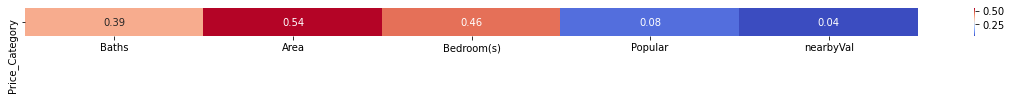

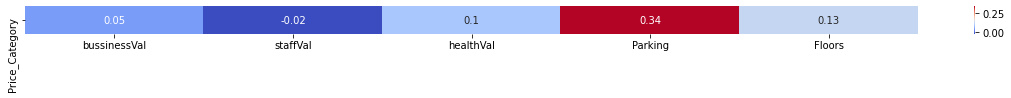

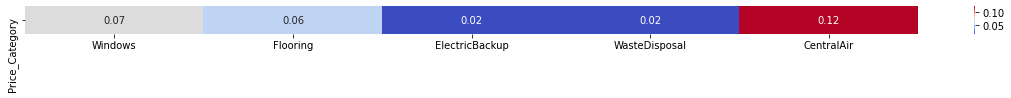

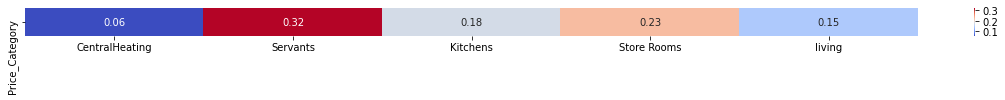

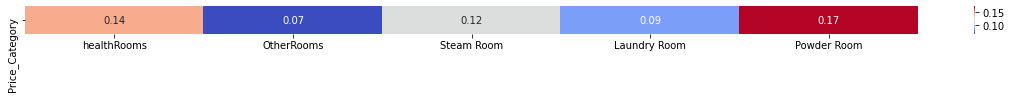

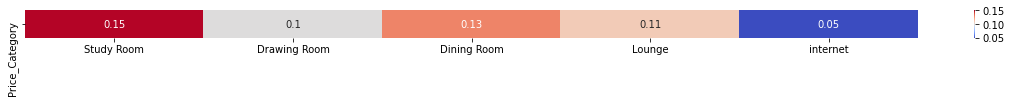

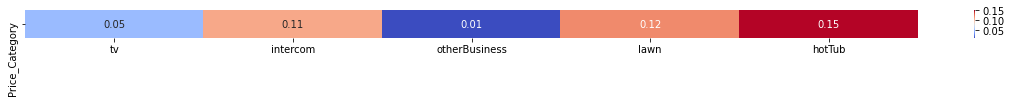

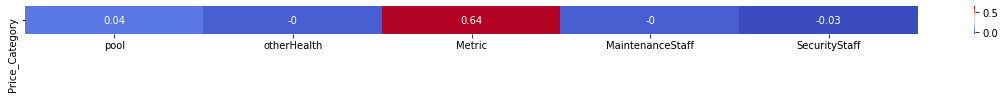

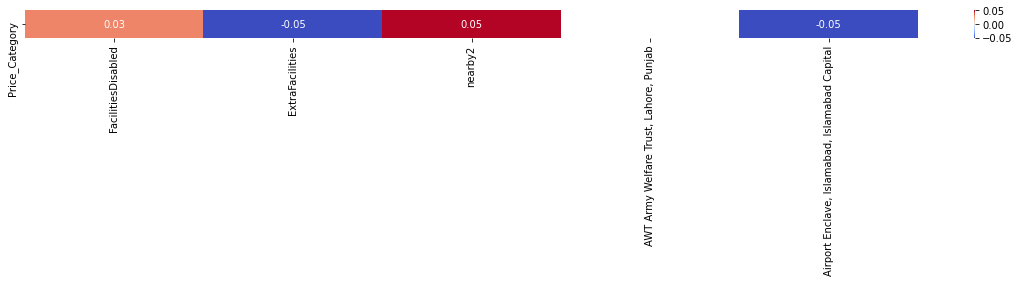

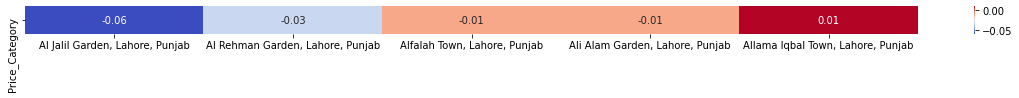

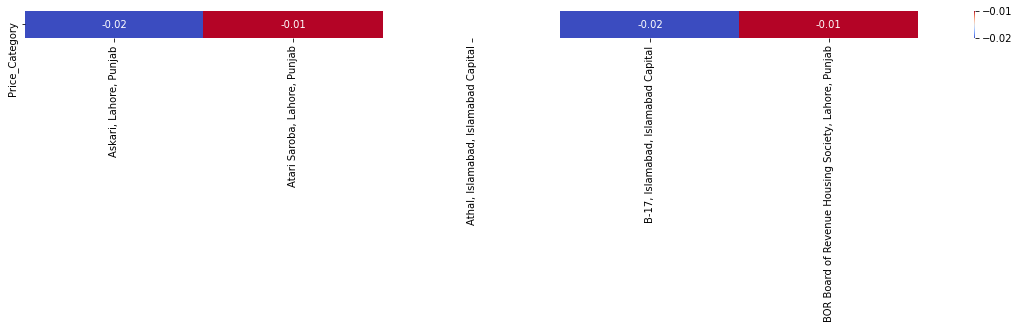

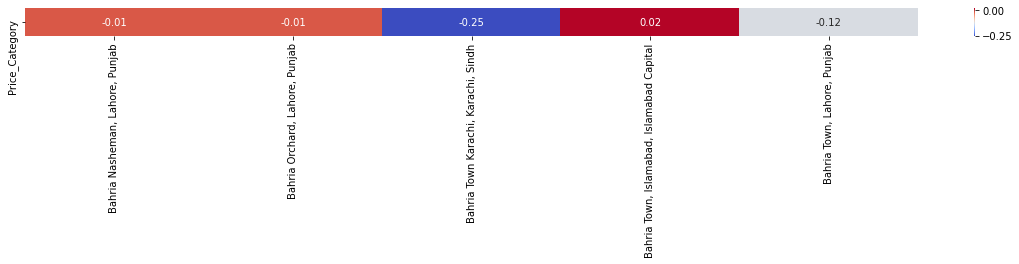

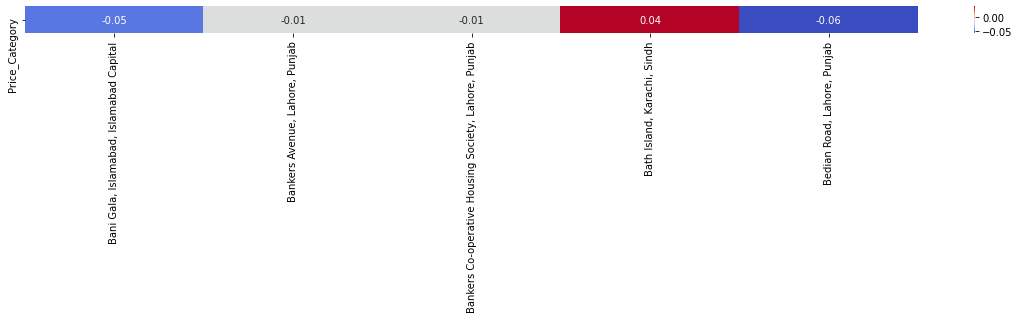

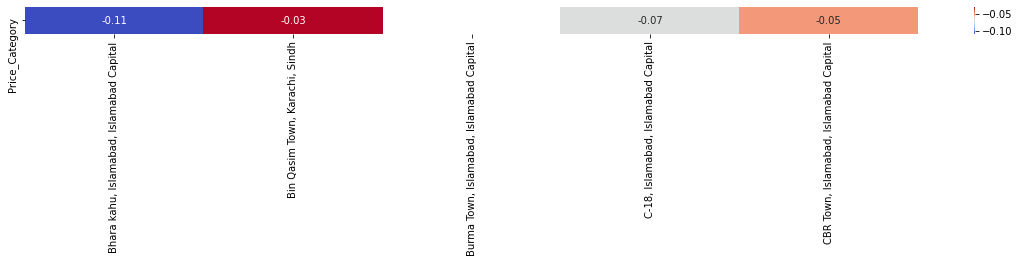

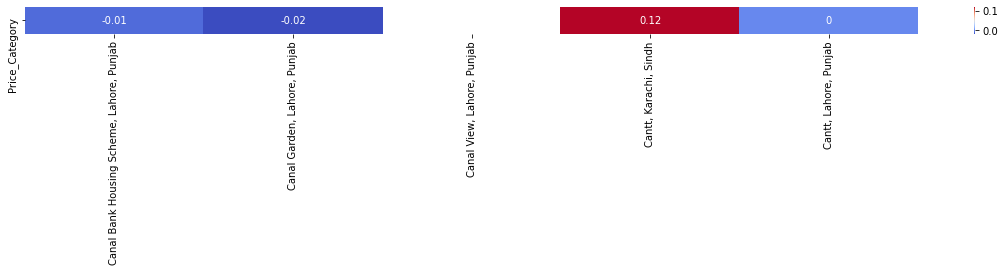

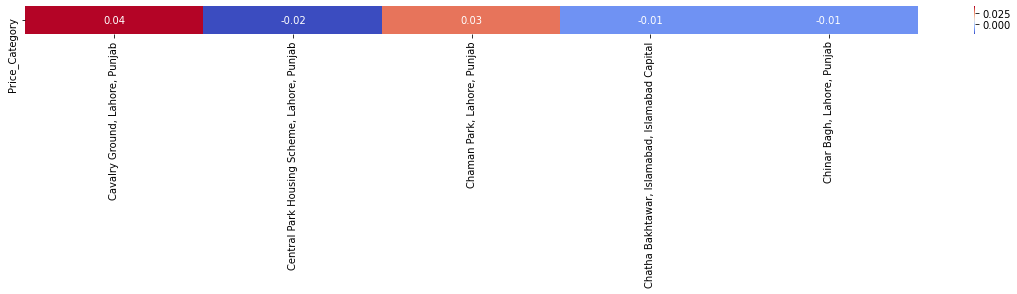

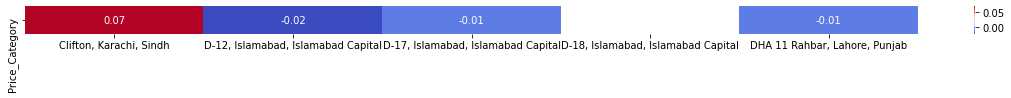

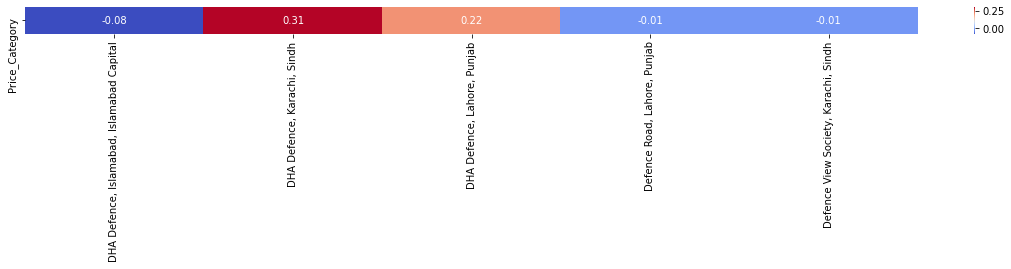

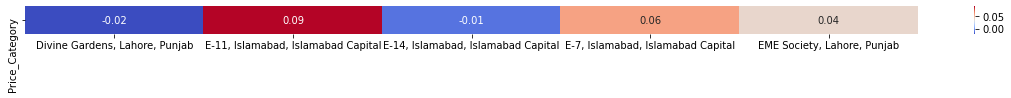

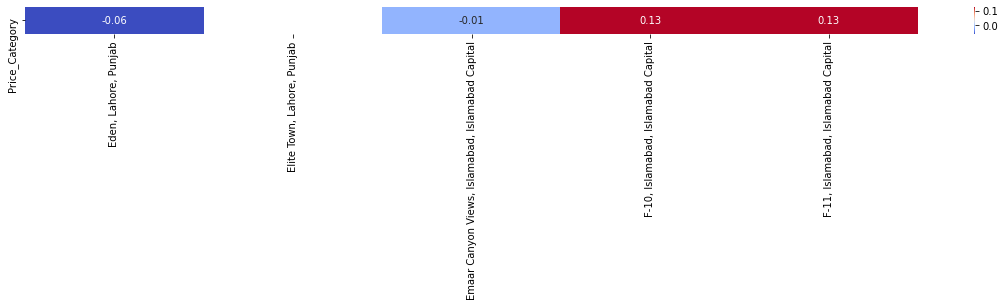

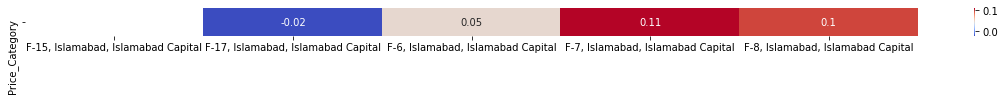

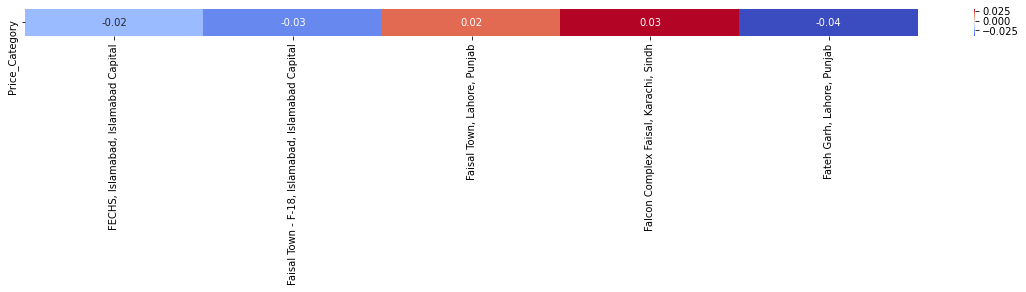

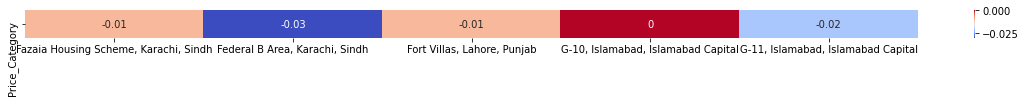

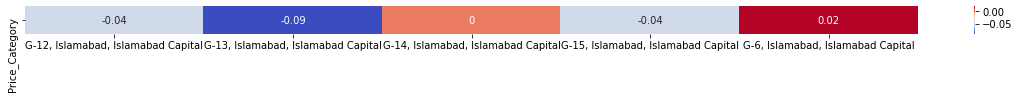

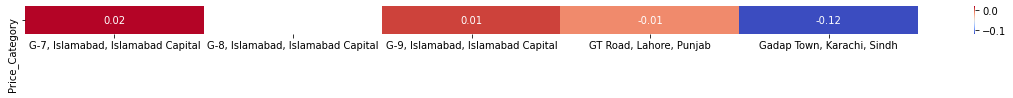

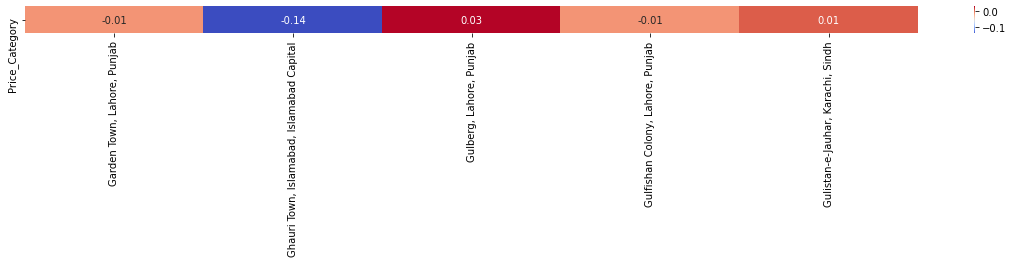

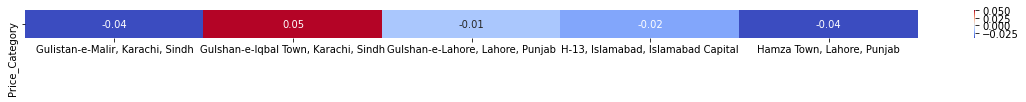

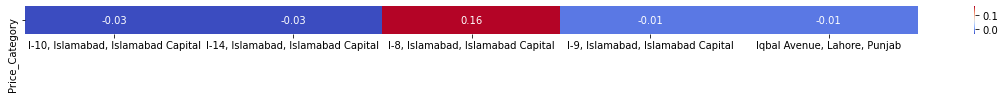

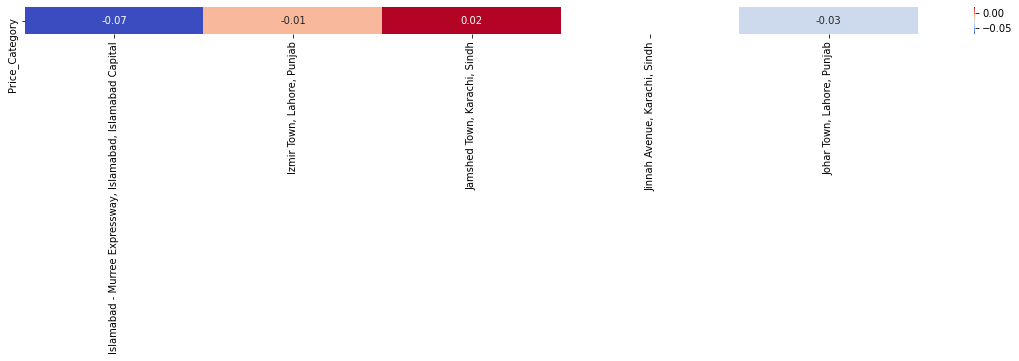

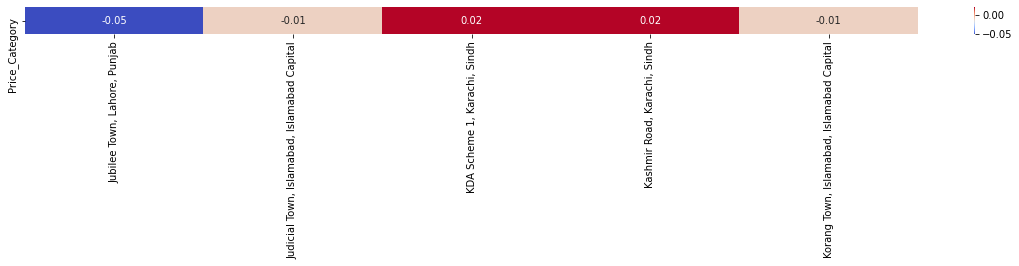

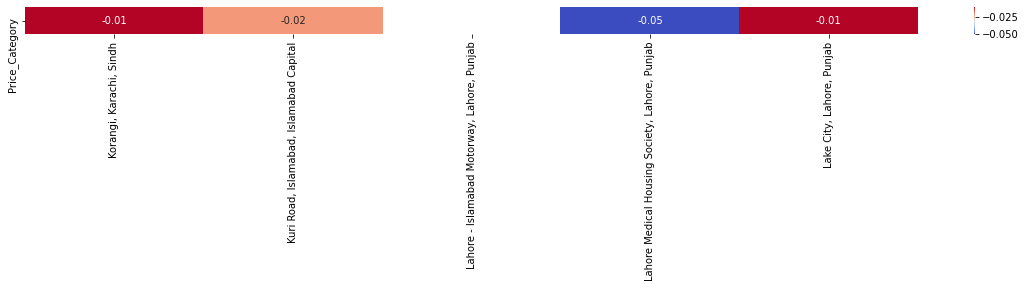

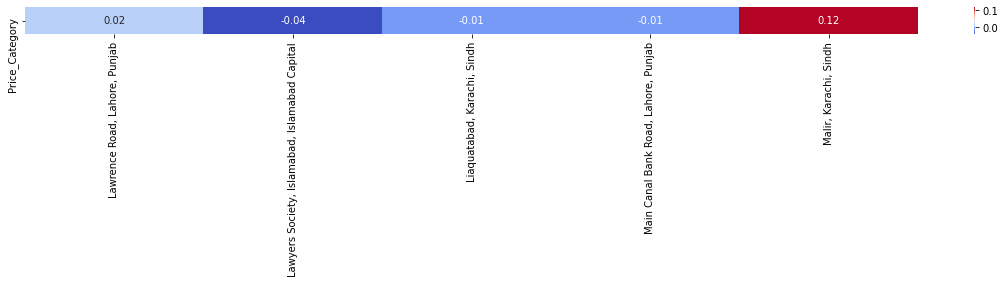

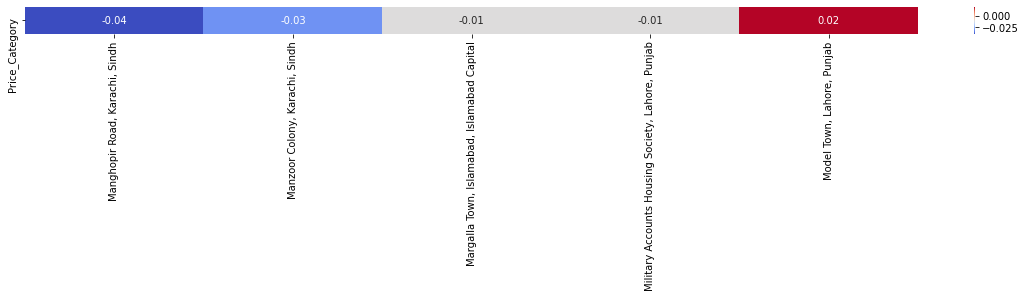

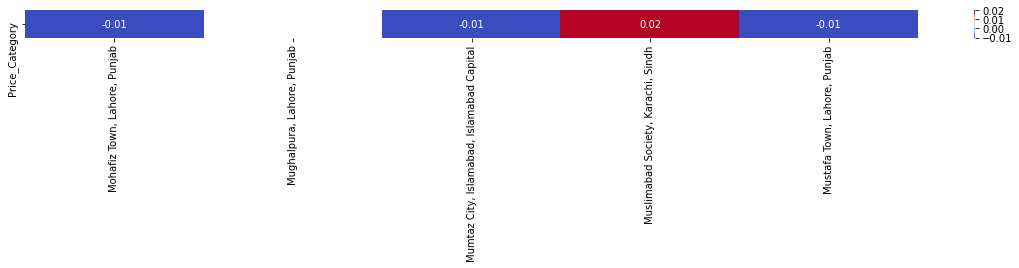

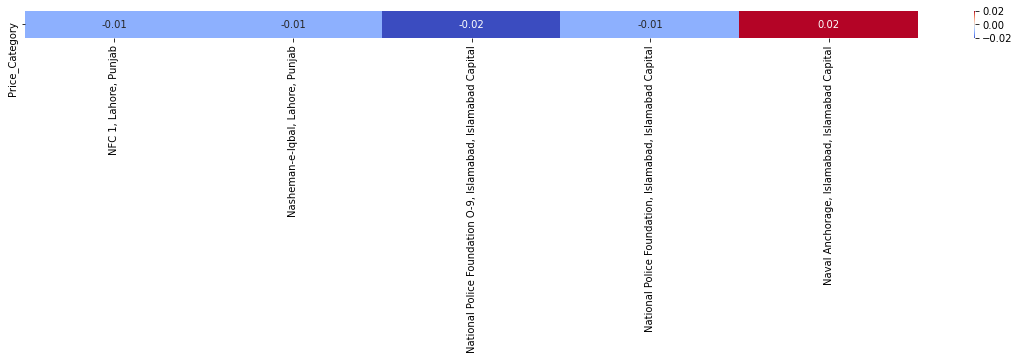

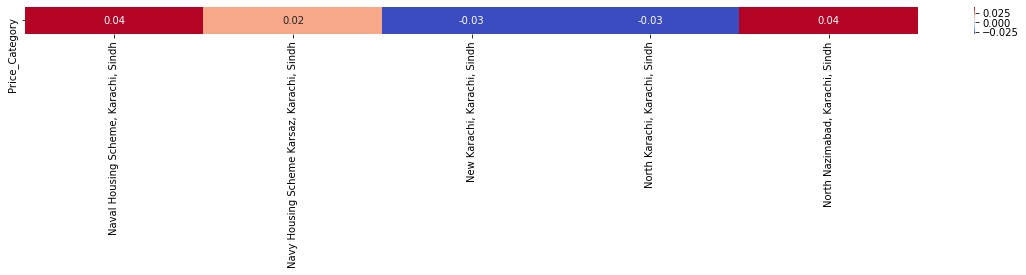

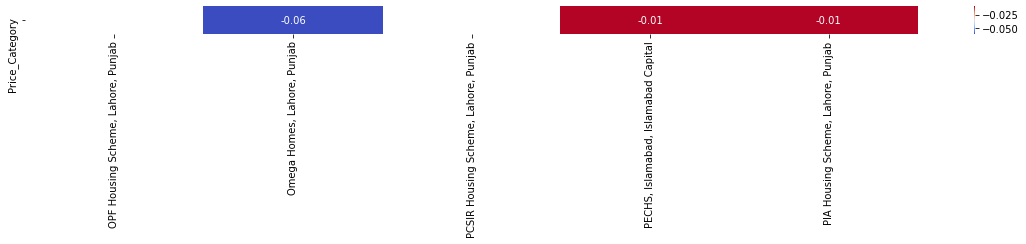

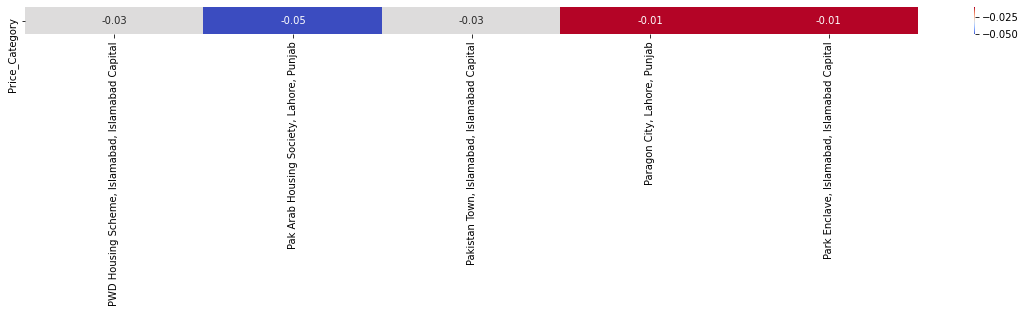

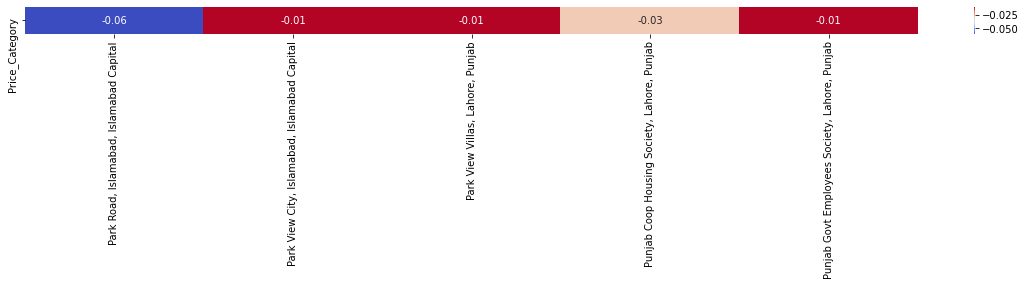

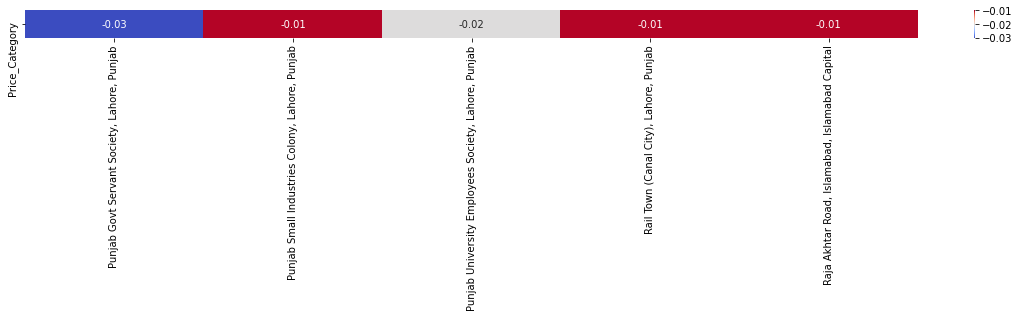

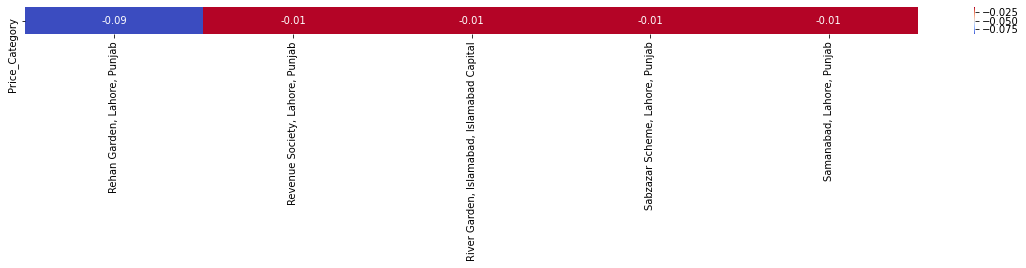

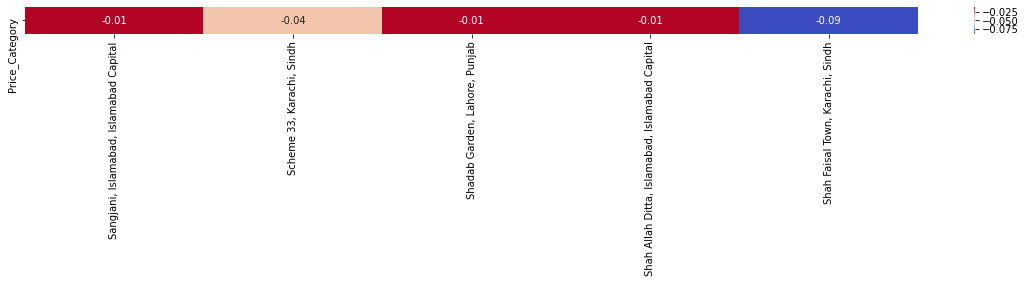

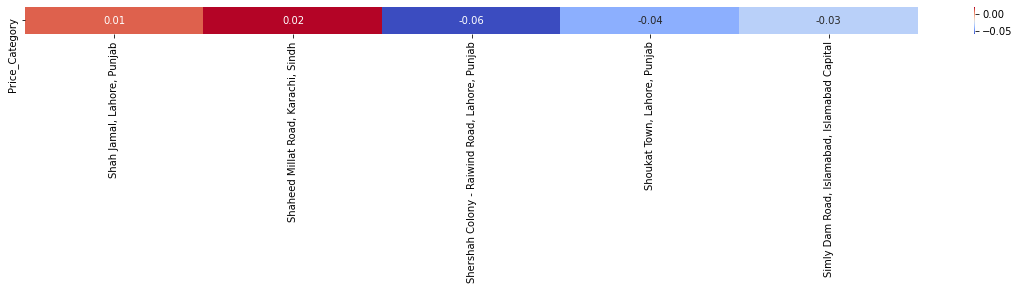

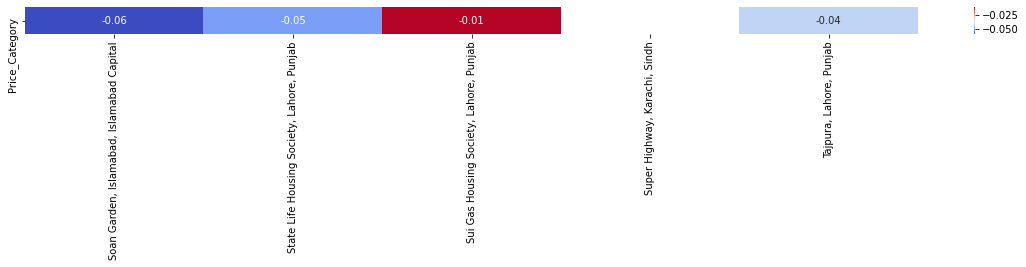

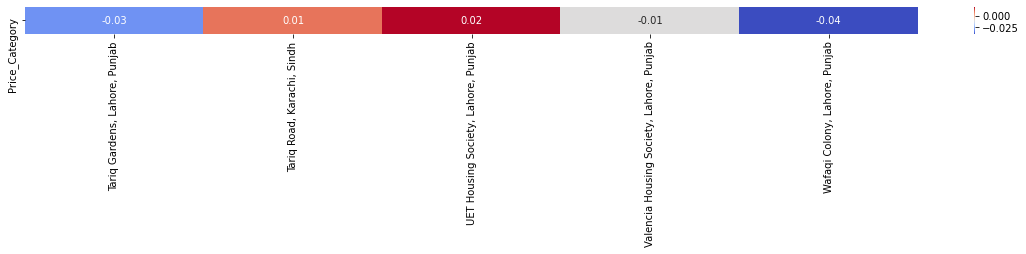

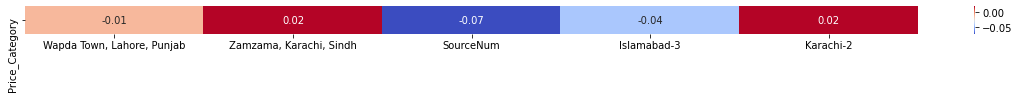

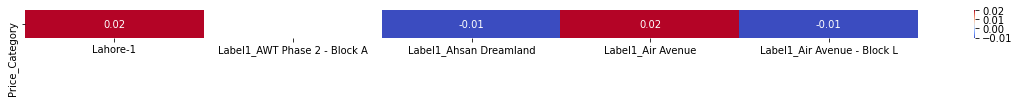

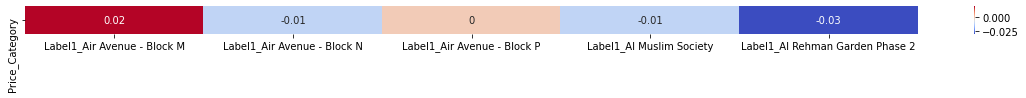

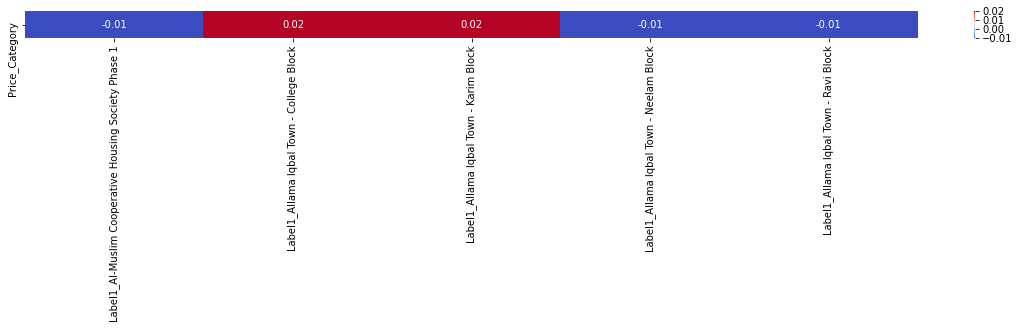

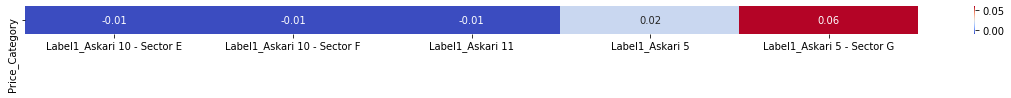

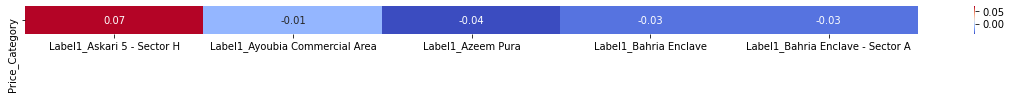

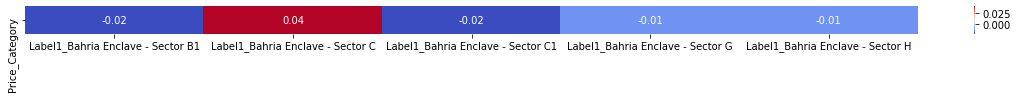

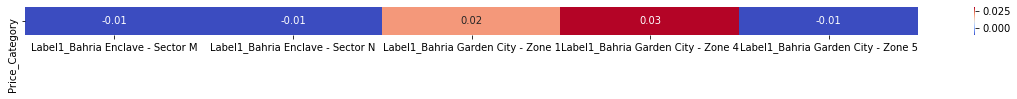

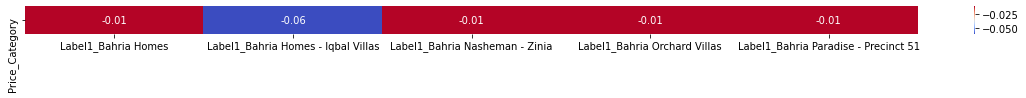

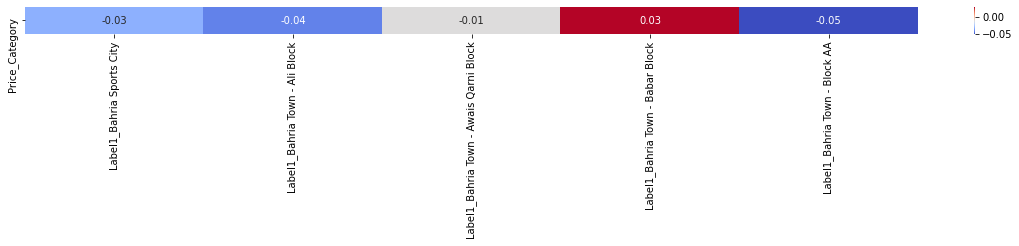

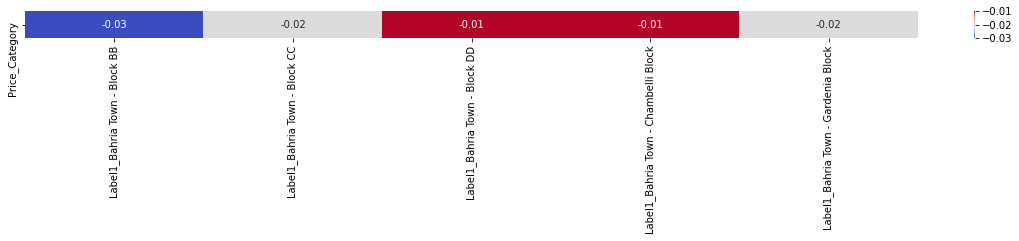

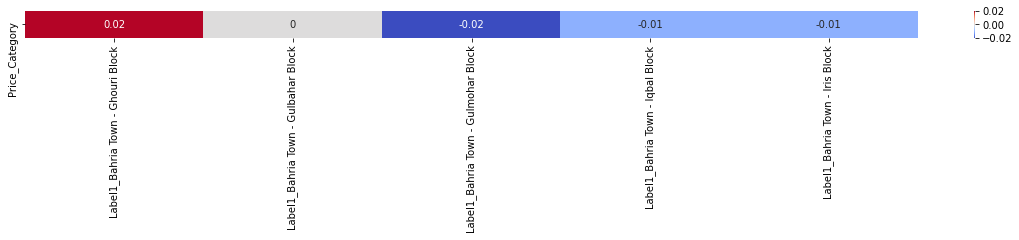

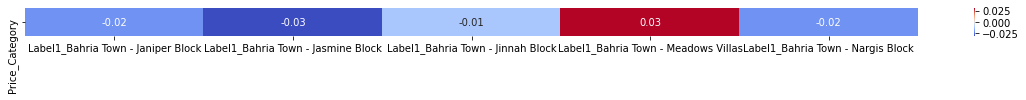

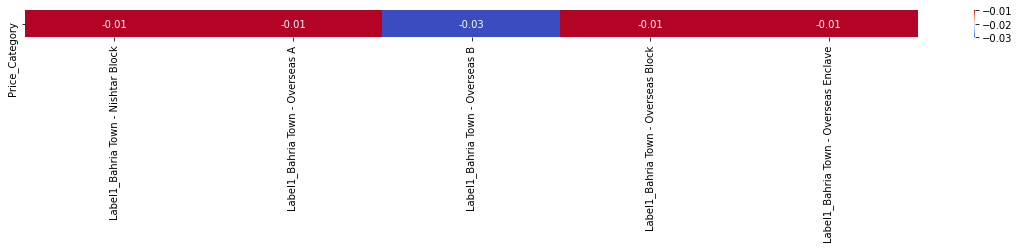

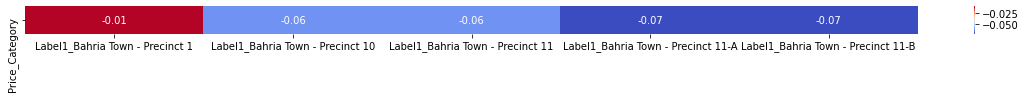

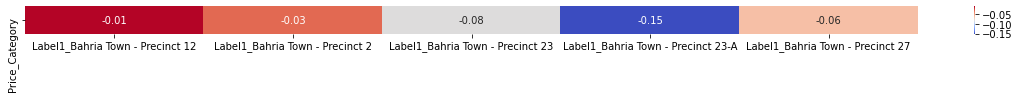

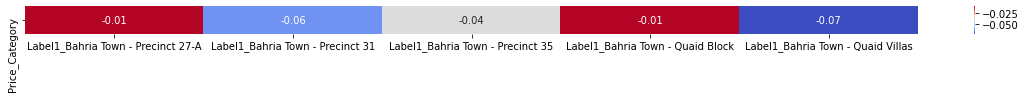

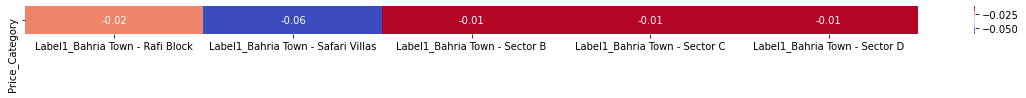

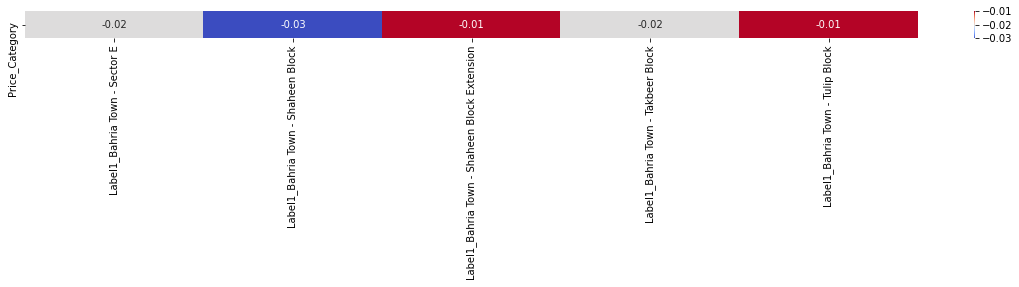

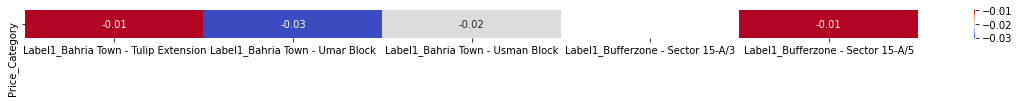

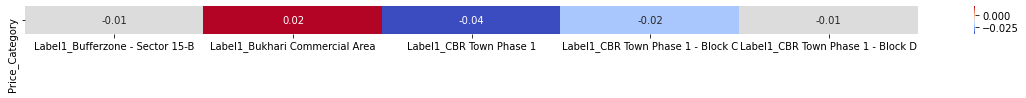

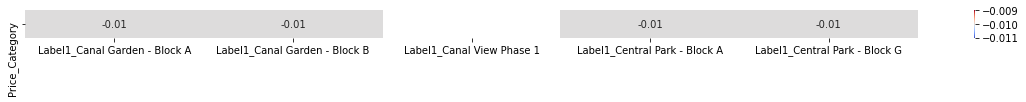

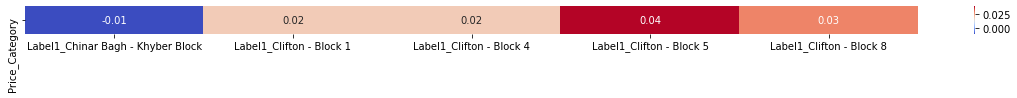

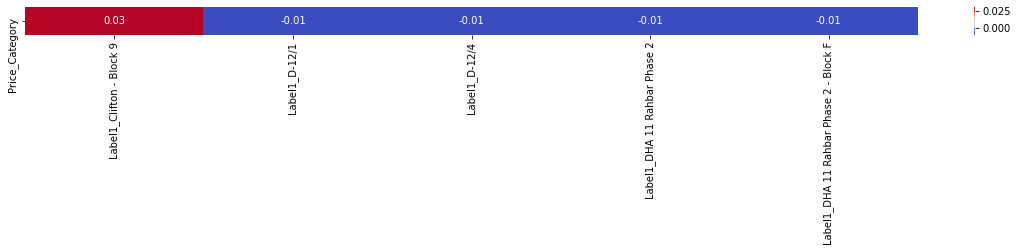

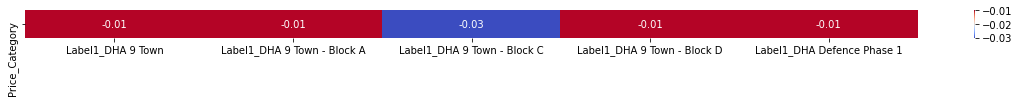

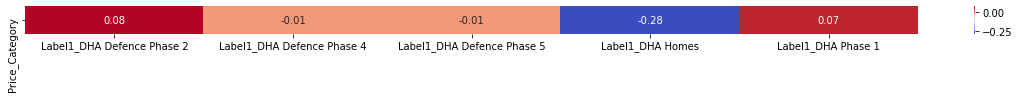

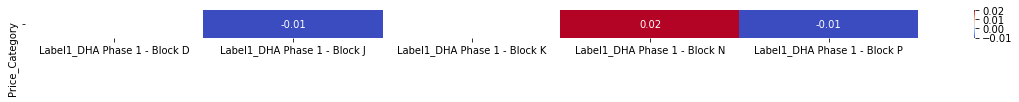

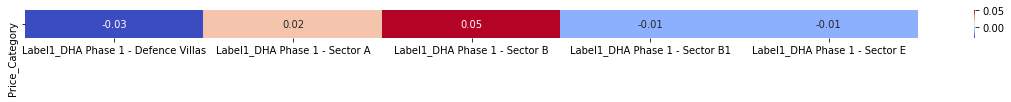

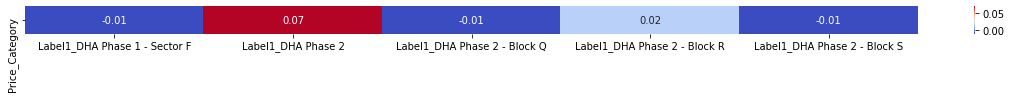

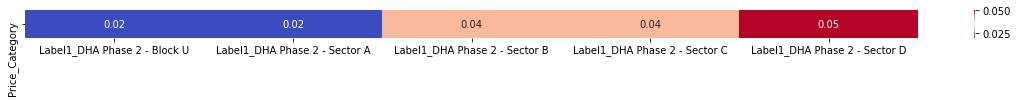

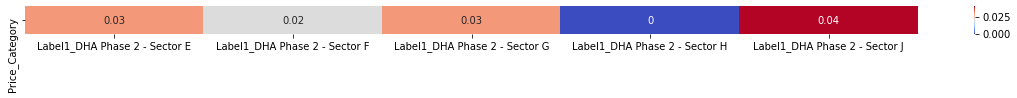

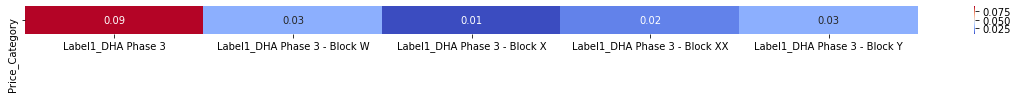

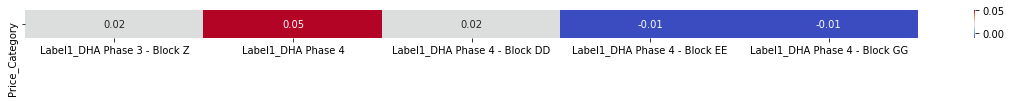

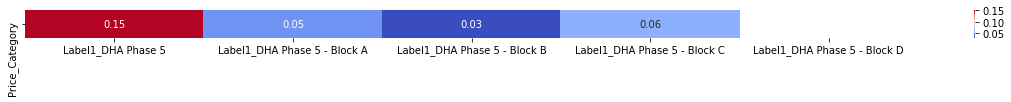

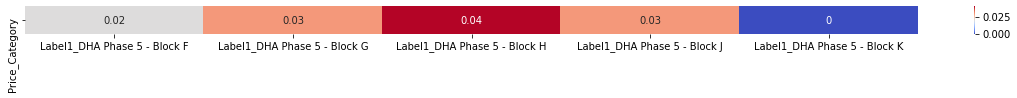

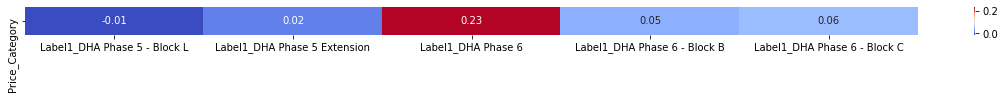

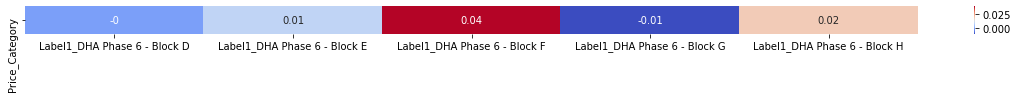

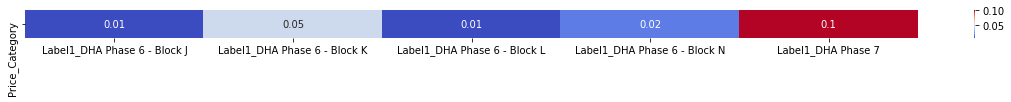

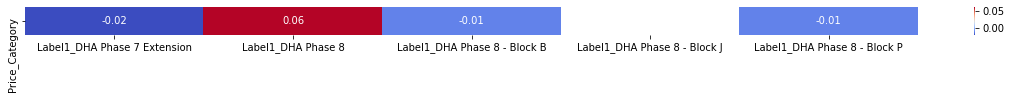

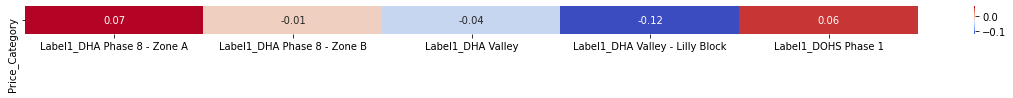

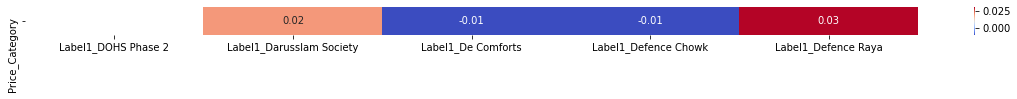

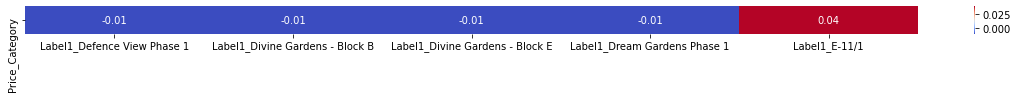

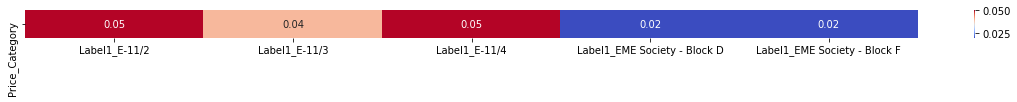

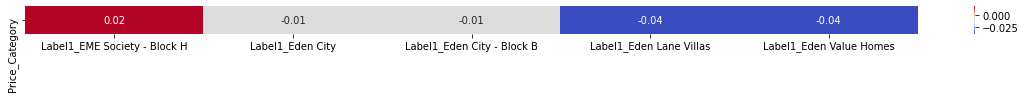

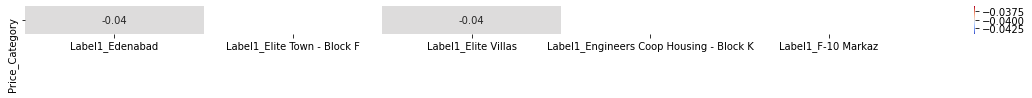

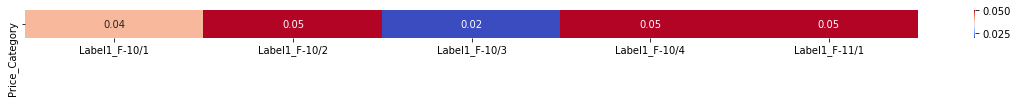

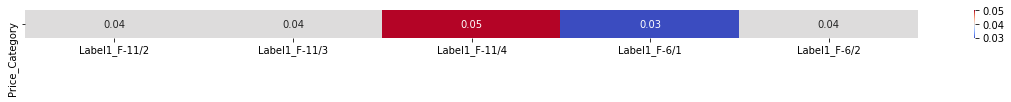

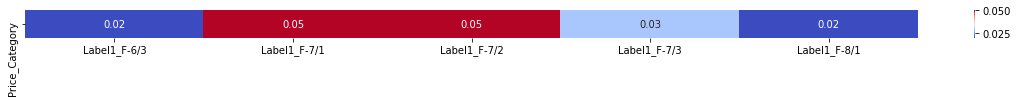

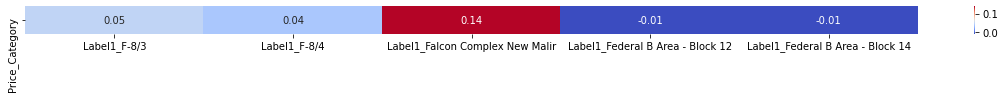

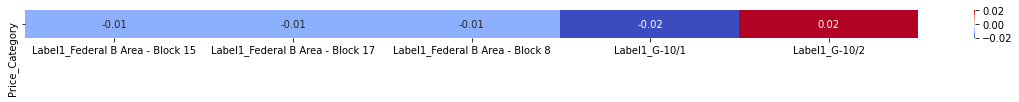

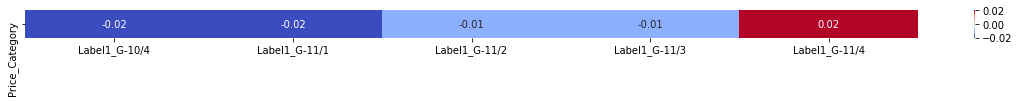

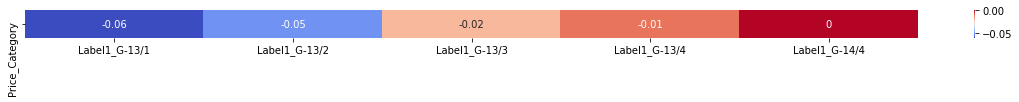

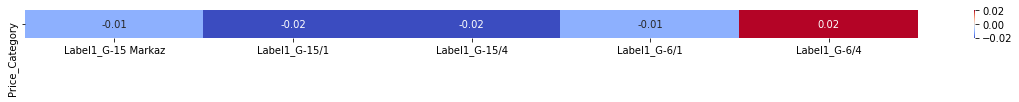

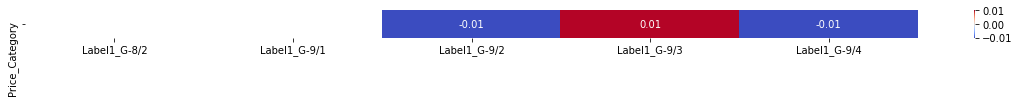

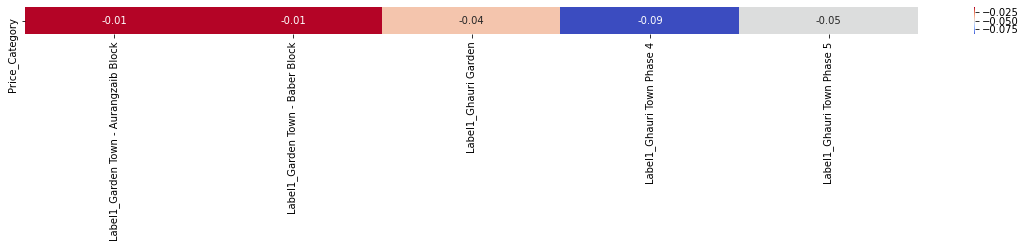

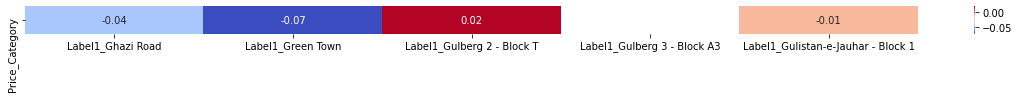

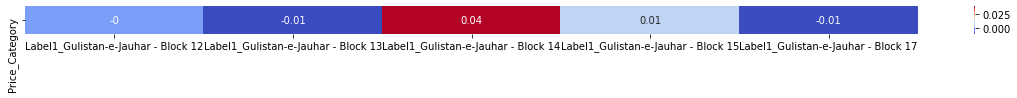

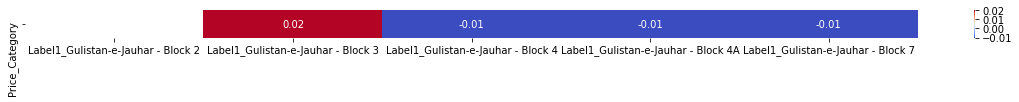

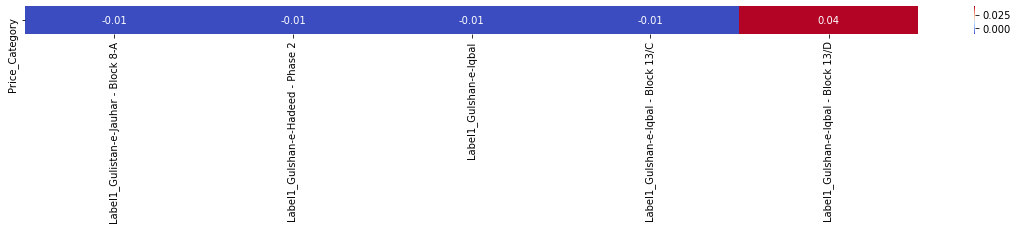

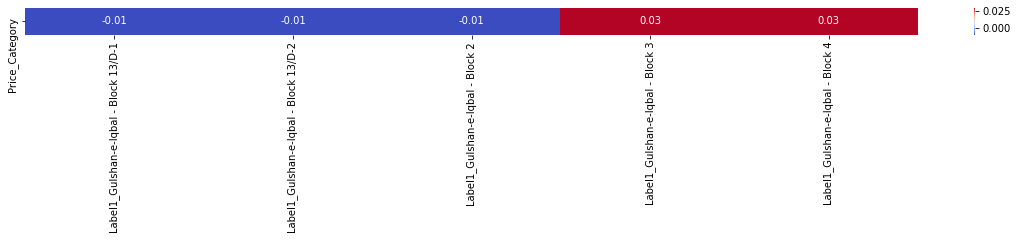

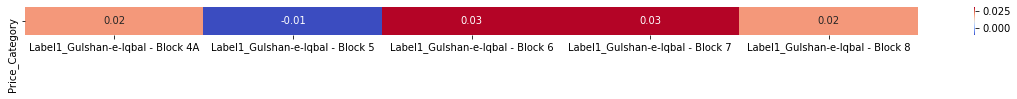

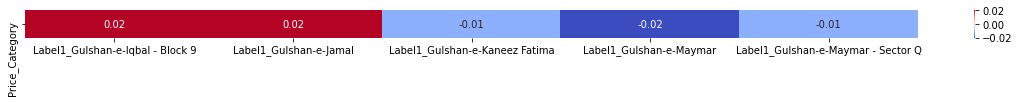

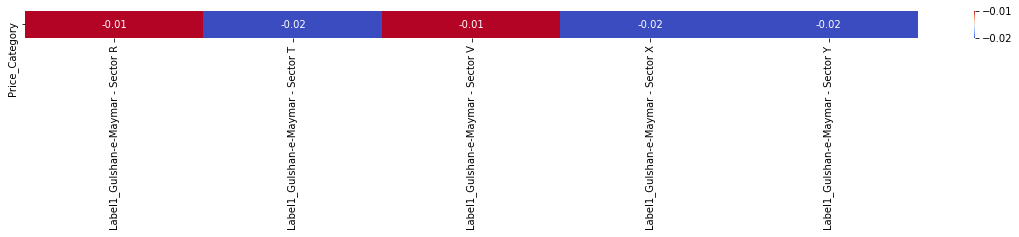

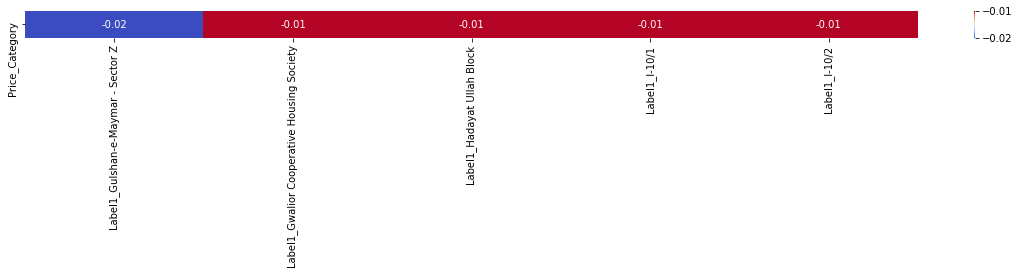

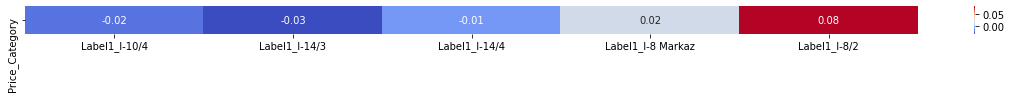

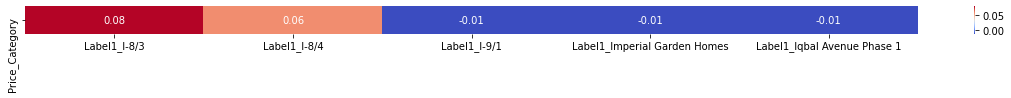

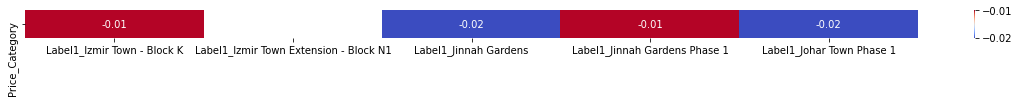

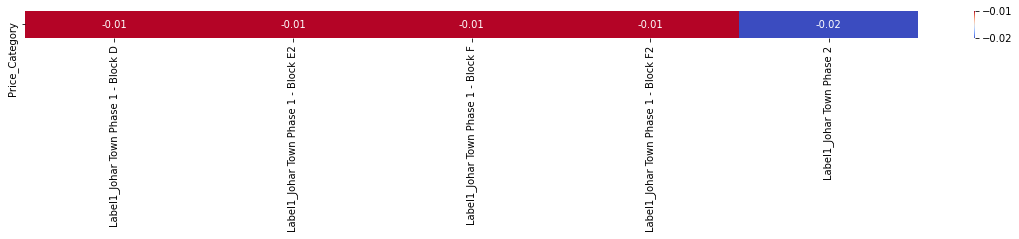

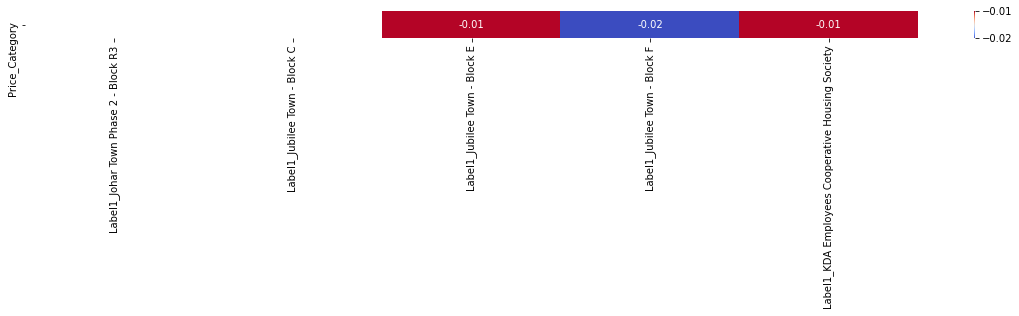

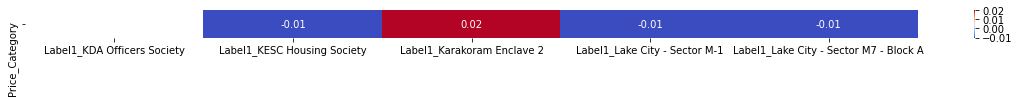

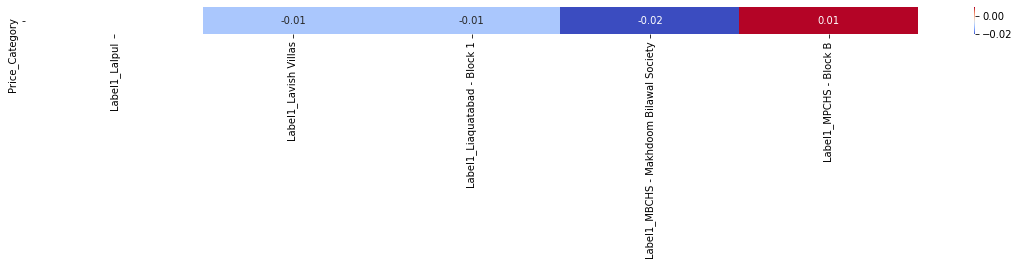

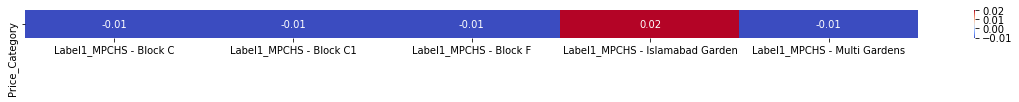

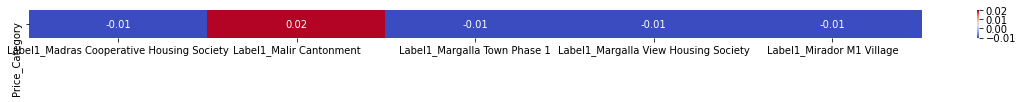

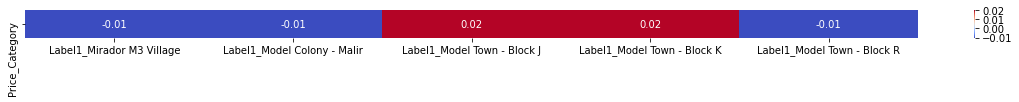

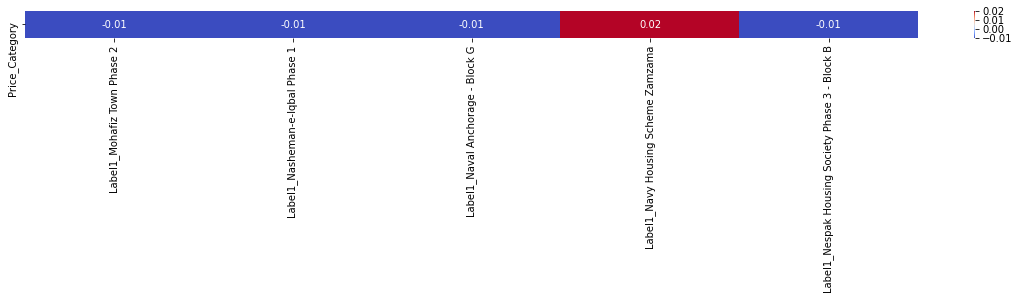

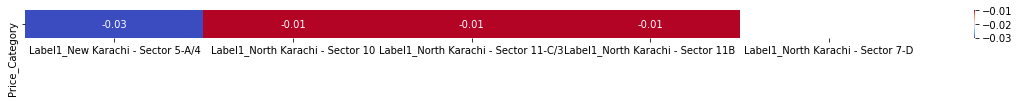

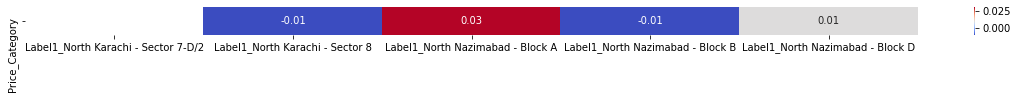

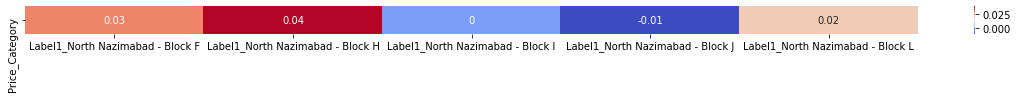

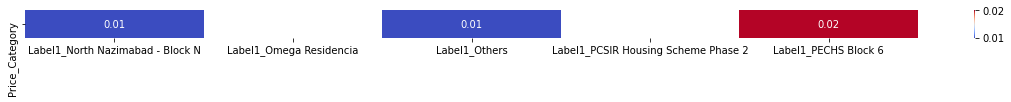

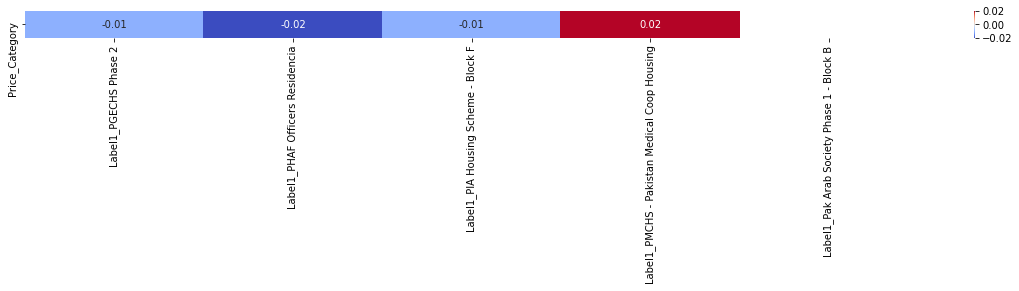

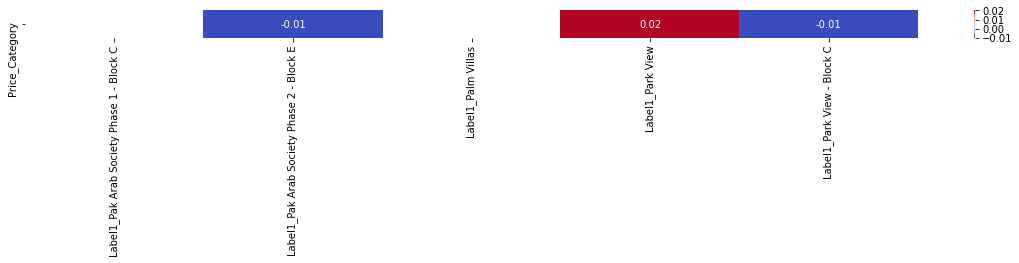

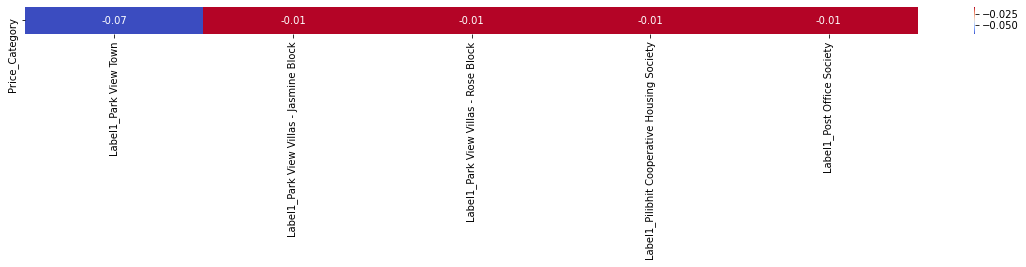

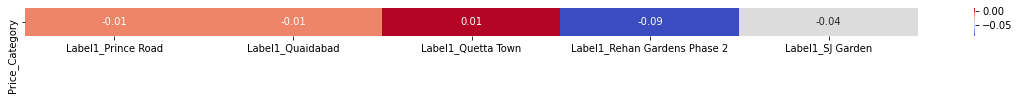

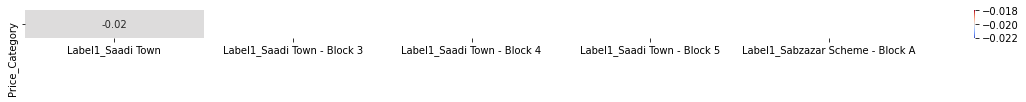

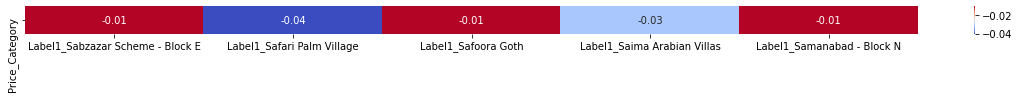

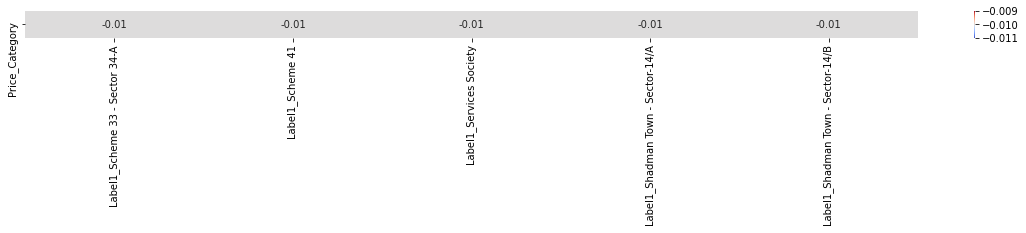

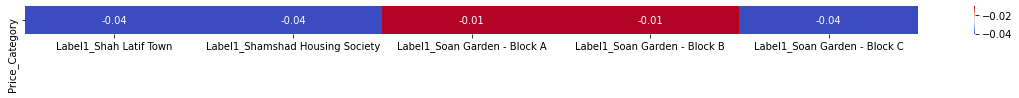

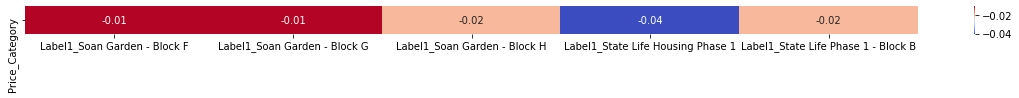

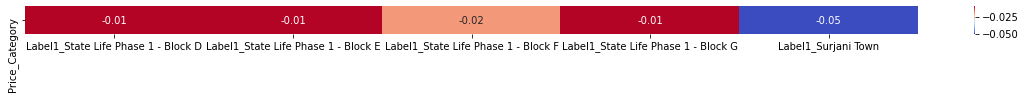

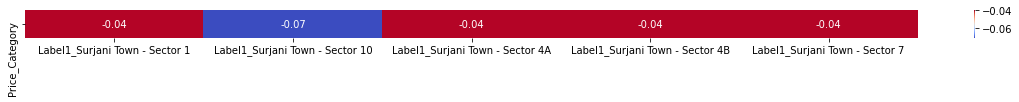

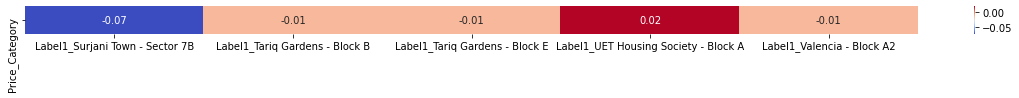

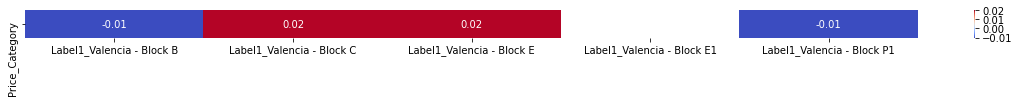

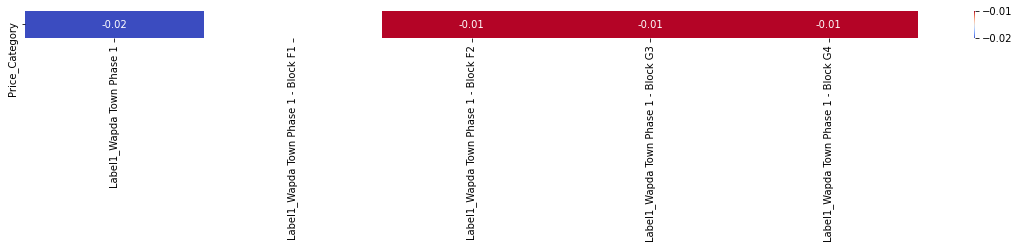

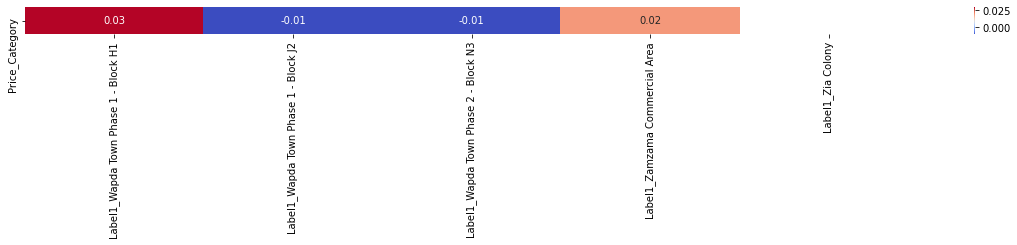

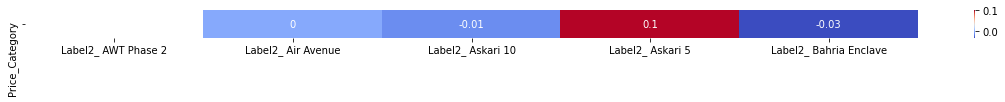

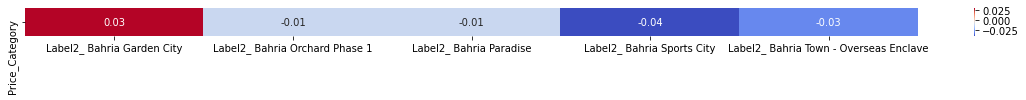

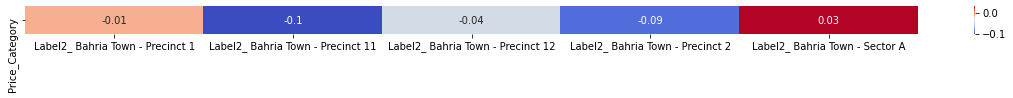

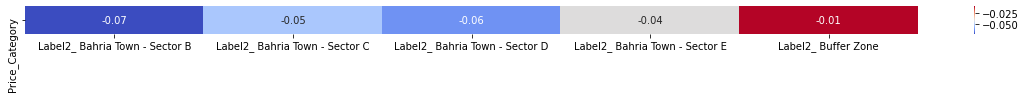

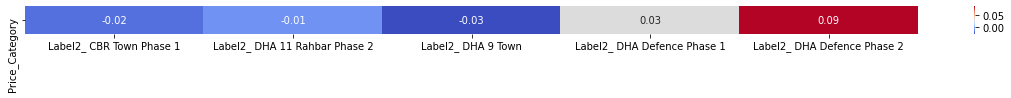

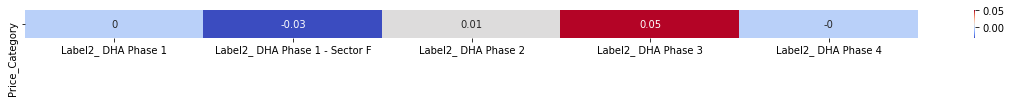

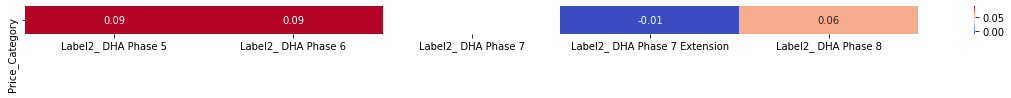

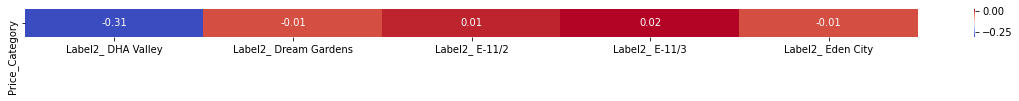

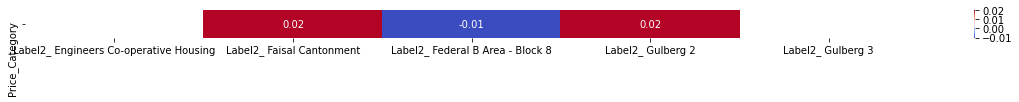

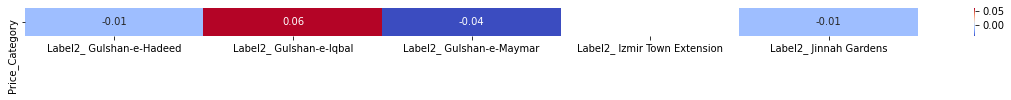

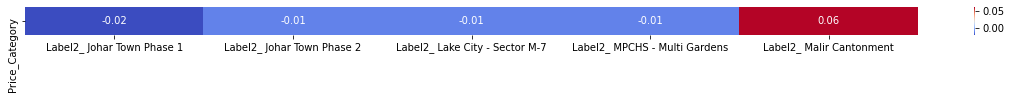

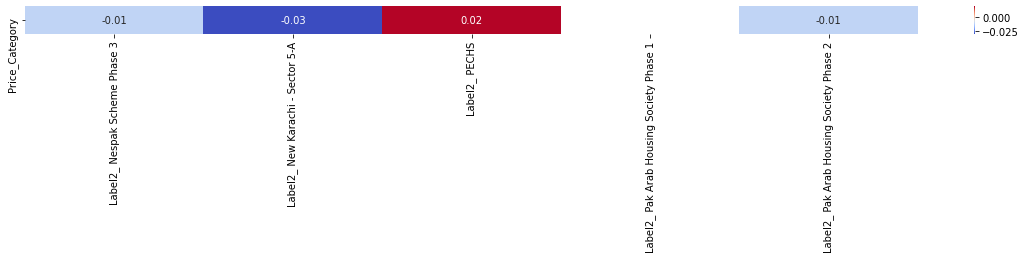

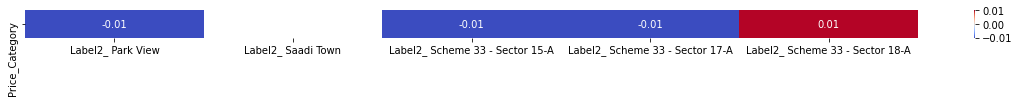

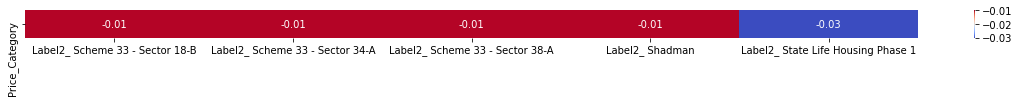

In [47]:
from math import ceil
ntrain = pd.concat([features[:len(y)],y],axis=1)
correlation_matrix = ntrain.corr().round(2)
matrix = correlation_matrix.loc[["Price_Category"]]
for x in range(ceil((len(ntrain.columns)-5)/5)):
    plt.figure(x,figsize = (20,.5))
    sns.heatmap(data=matrix.iloc[:,x*5:min(len(train),(x+1)*5)], cmap="coolwarm",annot=True)

In [48]:
def run_model(name, model,train,y,test):
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)
    model2 = model
    model2.fit(X_train,y_train)
    predictions = model.predict(X_test).round(0)
    print("%s F1 %s" % (name,f1_score(y_test, predictions, average='macro')))
    model.fit(train,y)
    preds = model.predict(test).round(0)
    return preds

In [49]:
models = [
    ("KNN",KNeighborsClassifier(n_neighbors=5)),
    ("LGBM",LGBMRegressor()),
    ("XGB",XGBRegressor())
]
for name,model in models:
    run_model(name, model, train,y,test)

KNN F1 0.5538330708316926
LGBM F1 0.7547321740677647
XGB F1 0.743795369712188


In [40]:
name = models[1][0]
model = models[1][1]
preds = run_model(name, model, train,y,test)

LGBM F1 0.7547321740677647


In [19]:
preds = [["Cheap","Affordable","Semi-Premium","Premium"][int(x)] for x in preds.round(0)]

In [20]:
sub = pd.DataFrame({"Property_Id":testId,"Price_Category":preds})

In [41]:
sub.to_csv("../output/sub_with_label_locs.csv",index=False)

NameError: name 'sub' is not defined

In [22]:
pre_sub = pd.read_csv("../output/sub_try_to_improve.csv")
pre_sub.Price_Category.value_counts()/len(pre_sub)

Semi-Premium    0.607339
Premium         0.352294
Affordable      0.040367
Name: Price_Category, dtype: float64

In [16]:
pre_sub2 = pd.read_csv("../output/sub3.csv")
pre_sub2.Price_Category.value_counts()/len(pre_sub)

Semi-Premium    0.598165
Premium         0.357798
Affordable      0.042202
Cheap           0.001835
Name: Price_Category, dtype: float64

In [45]:
sub["Price_Category"].value_counts()

Semi-Premium    331
Premium         192
Affordable       22
Name: Price_Category, dtype: int64

In [23]:
pd.concat([sub,pre_sub],axis=1)[sub.Price_Category != pre_sub.Price_Category]

,Property_Id,Price_Category,Property_Id,Price_Category
58,3124,Premium,3124,Semi-Premium
84,221,Affordable,221,Semi-Premium
116,3208,Semi-Premium,3208,Premium
176,3612,Semi-Premium,3612,Affordable
195,451,Premium,451,Semi-Premium
203,428,Semi-Premium,428,Premium
209,2293,Semi-Premium,2293,Premium
218,299,Premium,299,Semi-Premium
282,1586,Semi-Premium,1586,Premium
339,619,Semi-Premium,619,Premium


In [47]:
pd.concat([sub,pre_sub2],axis=1)[sub.Price_Category != pre_sub2.Price_Category]

,Property_Id,Price_Category,Property_Id,Price_Category
52,711,Semi-Premium,711,Premium
84,221,Semi-Premium,221,Affordable
176,3612,Affordable,3612,Semi-Premium
195,451,Semi-Premium,451,Premium
269,2576,Semi-Premium,2576,Premium
282,1586,Premium,1586,Semi-Premium
299,125,Semi-Premium,125,Affordable
303,2692,Premium,2692,Semi-Premium
368,1408,Semi-Premium,1408,Premium
377,2329,Affordable,2329,Semi-Premium
